In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


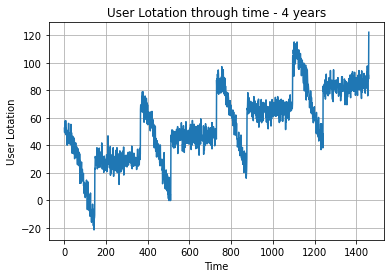

In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.title("User Lotation through time - 4 years")
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("User Lotation")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time,series)

In [15]:
tmp = tf.expand_dims(series,axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(tmp)
dataset = dataset.map(lambda x : tf.cast(x,tf.float32))
dataset = dataset.window(size=window_size+1,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda x : x.batch(window_size+1))
dataset = dataset.map(lambda x : (x[:-1], x[-1]))
dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters = 32, kernel_size = 5, padding='causal', activation='relu', input_shape = (window_size,1)
    ),
    tf.keras.layers.LSTM(32,return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100)
])

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate= 1e-8, momentum=0.9),
    loss = tf.keras.losses.Huber(),
    metrics = ["mae"]
)


In [8]:
#basically it increases in each epoch, but between 20 and 20 epochs we have a jump 10 times greates than the original lr
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**(epoch/20)
)
'''
model.fit(
    dataset,
    epochs = 100,
    shuffle = True,
    callbacks = [learning_rate_scheduler]
)
''

Epoch 1/100
46/46 [==============================] - 3s 12ms/step - loss: 87.2322 - mae: 87.7322
Epoch 2/100
46/46 [==============================] - 1s 11ms/step - loss: 74.9039 - mae: 75.4036
Epoch 3/100
46/46 [==============================] - 1s 11ms/step - loss: 41.3873 - mae: 41.8851
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: 15.2623 - mae: 15.7548
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 12.4252 - mae: 12.9152
Epoch 6/100
46/46 [==============================] - 1s 11ms/step - loss: 11.5058 - mae: 11.9990
Epoch 7/100
46/46 [==============================] - 1s 11ms/step - loss: 11.4250 - mae: 11.9171
Epoch 8/100
46/46 [==============================] - 1s 11ms/step - loss: 11.0414 - mae: 11.5309
Epoch 9/100
46/46 [==============================] - 1s 11ms/step - loss: 10.7738 - mae: 11.2634
Epoch 10/100
46/46 [==============================] - 1s 11ms/step - loss: 10.9584 - mae: 11.4457
Epoch 11/100
46/46 [=========

KeyboardInterrupt: ignored

(1e-08, 0.001, 0.0, 40.0)

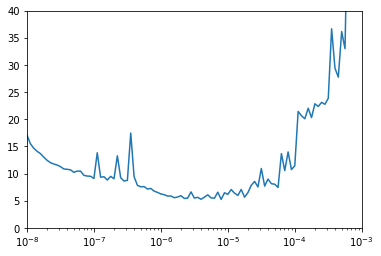

In [ ]:
#loss = model.history.history['loss']
#plt.plot(np.linspace(start = 1e-8, stop = 1e-4, num = len(loss) )  ,loss);
#plt.axis([1e-8,1e-4,0,40])

plt.semilogx(model.history.history["lr"], model.history.history["loss"])
plt.axis([1e-8, 1e-3,0,40])

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters = 32, kernel_size = 5, padding='causal', activation='relu', input_shape = (window_size,1)
    ),
    tf.keras.layers.LSTM(32,return_sequences=False),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100)
])

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate= 1e-8, momentum=0.9),
    loss = tf.keras.losses.Huber(),
    metrics = ["mae"]
)

model.fit(
    dataset,
    epochs = 300,
    shuffle = True,
)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1]

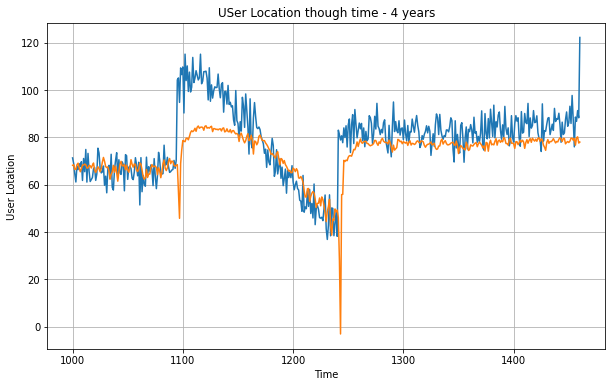

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.reduce_mean(tf.keras.metrics.MAE(x_valid, rnn_forecast).numpy())

<tf.Tensor: shape=(), dtype=float32, numpy=14.822862>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=model.history.history['mae']
loss=model.history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

KeyError: ignored